In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Load the dataset
file_path = '/content/drive/MyDrive/IPD dataset.csv'
df_original = pd.read_csv(file_path)
df = pd.read_csv(file_path)

# Display basic information about the dataset
df.info(), df.head()

# Dimension
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2741 entries, 0 to 2740
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ID            2741 non-null   int64 
 1   Episode Date  2713 non-null   object
 2   Year          2741 non-null   int64 
 3   Serotype      1189 non-null   object
 4   Age           2741 non-null   int64 
 5   Gender        2741 non-null   object
 6   HSDA          2741 non-null   object
 7   HA            2741 non-null   object
 8   Offset PC     2659 non-null   object
dtypes: int64(3), object(6)
memory usage: 192.9+ KB


(2741, 9)

In [2]:
#subtypes of IPD cases
num_unique_subtypes = df['Serotype'].nunique()

# Display the count of unique IPD subtypes
print(num_unique_subtypes)

71


In [3]:
#generate missing table

# Replace NA, empty strings, spaces, 'U', and 'Unknown' with 'missing'
df = df.applymap(lambda x: 'missing' if pd.isna(x) or str(x).strip() in ['', 'U', 'Unknown'] else x)

# Count and percentage of missing values for each variable
missing_counts = (df == 'missing').sum()
missing_percentages = ((df == 'missing').mean() * 100).round(2)

# Create a summary table
summary_table = pd.DataFrame({
    'Missing Count': missing_counts,
    'Missing Percentage (%)': missing_percentages
})

# Display the summary table
print(summary_table)


              Missing Count  Missing Percentage (%)
ID                        0                    0.00
Episode Date             28                    1.02
Year                      0                    0.00
Serotype               1553                   56.66
Age                       0                    0.00
Gender                    1                    0.04
HSDA                      0                    0.00
HA                        0                    0.00
Offset PC                82                    2.99


<ipython-input-3-dee16312788d>:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 'missing' if pd.isna(x) or str(x).strip() in ['', 'U', 'Unknown'] else x)


#

#Identify Duplicates#

In [4]:
# Identify duplicate records
duplicates = df[df.duplicated(keep=False)]

# Count of duplicate records
num_duplicates = duplicates.shape[0]

# Remove duplicates
df_unique = df.drop_duplicates()

# Number of duplicates removed
duplicates_removed = df.shape[0] - df_unique.shape[0]

duplicates_removed, df_unique.shape

#The dataset contains only unique records, so no duplicates were removed.

(0, (2741, 9))

#Identify errors#

In [5]:

# Check for out-of-range ages
out_of_range_age = df_unique[(df_unique['Age'] < 0) | (df_unique['Age'] > 110)]

# Check for invalid gender values
invalid_gender = df_unique[df_unique['Gender'].isin(['U'])]

# Check for outlier years outside 2000-2020
outlier_year_case = df_unique[(df_unique['Year'] < 2000) | (df_unique['Year'] > 2020)]
outlier_year_case

# Record the errors
errors_summary_updated = {
    "Out of range age": len(out_of_range_age),
    "Invalid gender (U)": len(invalid_gender),
    "Outlier year of case": len(outlier_year_case),
    "Total errors identified": len(out_of_range_age) + len(invalid_gender) + len(outlier_year_case)
}

# Display identified errors
errors_details = {
    "Out of Range Age": out_of_range_age,
    "Invalid Gender": invalid_gender,
    "Outlier Year of Case": outlier_year_case
}

for error_type, df in errors_details.items():
    if not df.empty:
        print(f"\n{error_type} Errors:")
        print(df)

errors_summary_updated

# Combine the indices of all error types
error_indices = set(out_of_range_age.index).union(
    invalid_gender.index,
    outlier_year_case.index
)

# Remove the error records from the dataset
df_cleaned = df_unique.drop(index=error_indices)
print(df_cleaned.columns.tolist())

df_cleaned.shape




Out of Range Age Errors:
      ID Episode Date  Year Serotype  Age Gender      HSDA        HA Offset PC
308  363    14-Feb-07  2007  missing   -2      F  Okanagan  Interior    V1T8M3

Outlier Year of Case Errors:
        ID Episode Date  Year Serotype  Age Gender                    HSDA  \
2738  4303      missing     0       D4    0      M  South Vancouver Island   

                    HA Offset PC  
2738  Vancouver Island    V8K1A1  
['ID', 'Episode Date', 'Year', 'Serotype', 'Age', 'Gender', 'HSDA', 'HA', 'Offset PC']


(2739, 9)

#Identify Structural Issues#

In [6]:
# Convert 'Episode Date' to datetime format
df_cleaned['Episode Date'] = pd.to_datetime(df_cleaned['Episode Date'], errors='coerce')

# Now identify the mismatched record
mismatched_year_corrected = df_cleaned[
    (df_cleaned['Episode Date'].notnull()) &
    (df_cleaned['Year'] != df_cleaned['Episode Date'].dt.year)
]

# Display mismatched records
print(mismatched_year_corrected)

# Remove the mismatched record
df_cleaned = df_cleaned.drop(index=mismatched_year_corrected.index)

# Display the updated dataset shape
df_cleaned.shape

df_cleaned.to_csv('df_cleaned.csv', index=False)
df_cleaned.shape


<ipython-input-6-c7c0f89ba0a7>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_cleaned['Episode Date'] = pd.to_datetime(df_cleaned['Episode Date'], errors='coerce')


        ID Episode Date  Year Serotype  Age Gender          HSDA      HA  \
2439  3975   2006-11-27  2007      D41   30      M  Fraser South  Fraser   

     Offset PC  
2439    V3T2Z2  


(2738, 9)

#Fix missing data#

In [7]:
# Identify missing values, including NaN, empty strings, spaces, 'Unknown', and 'Pending'
missing_values = (df.isna() | (df == "") | (df == " ") | (df == "Unknown") | (df == "Pending")).sum()

# Convert to a DataFrame with missing percentages
missing_table = pd.DataFrame({
    'Variable': missing_values.index,
    'Missing_Percentage': (missing_values / len(df)) * 100
})

# Display the missing table
print(missing_table)

df_cleaned.shape

                  Variable  Missing_Percentage
ID                      ID                 0.0
Episode Date  Episode Date                 0.0
Year                  Year                 0.0
Serotype          Serotype                 0.0
Age                    Age                 0.0
Gender              Gender                 0.0
HSDA                  HSDA                 0.0
HA                      HA                 0.0
Offset PC        Offset PC                 0.0


(2738, 9)

In [8]:
#drop serotype column (feature drop)
df_cleaned = df_cleaned.drop(columns=['Serotype'])

# Display the updated dataset shape to confirm
df_cleaned.shape



(2738, 8)

In [9]:
#check rows that have missing data
# Calculate the number of missing values per row
missing_counts = df_cleaned.isnull().sum(axis=1)

# Set the threshold for 40% missing values
threshold_40_percent = df_cleaned.shape[1] * 0.1

# Filter rows with more than 40% missing values
rows_with_40_percent_missing = df_cleaned[missing_counts > threshold_40_percent]

rows_with_40_percent_missing

#no rows with >40% missing values

,ID,Episode Date,Year,Age,Gender,HSDA,HA,Offset PC
2462,4017,NaT,2007,30,F,Vancouver,Vancouver Coastal,V6G2Z6
2484,4044,NaT,2007,48,M,Okanagan,Interior,V1Y7E1
2493,4053,NaT,2007,39,M,North Vancouver Island,Vancouver Island,V9N3C4
2496,4056,NaT,2007,69,M,North Shore/Coast Garibal,Vancouver Coastal,V0N2S0
2498,4058,NaT,2007,35,M,Fraser South,Fraser,V3V6X9
2501,4061,NaT,2007,56,M,Fraser North,Fraser,V3H2K3
2505,4065,NaT,2007,45,F,Fraser North,Fraser,V2X5P6
2507,4067,NaT,2007,39,M,South Vancouver Island,Vancouver Island,V8S4R6
2513,4073,NaT,2007,30,M,Fraser South,Fraser,V3T3W5
2525,4085,NaT,2007,32,M,Central Vancouver Island,Vancouver Island,V9Y6E8


#Descriptive analyses#  


##by person

In [10]:
# Tabulate the number of IPD cases by Gender
gender_counts = df_cleaned['Gender'].value_counts()

# Calculate percentage of cases by Gender
gender_percentages = (gender_counts / gender_counts.sum()) * 100

# Display the counts and percentages
print("IPD Cases by Gender:")
print(gender_counts)
print("\nPercentage of IPD Cases by Gender:")
print(gender_percentages)


IPD Cases by Gender:
Gender
M          1534
F          1203
missing       1
Name: count, dtype: int64

Percentage of IPD Cases by Gender:
Gender
M          56.026297
F          43.937180
missing     0.036523
Name: count, dtype: float64


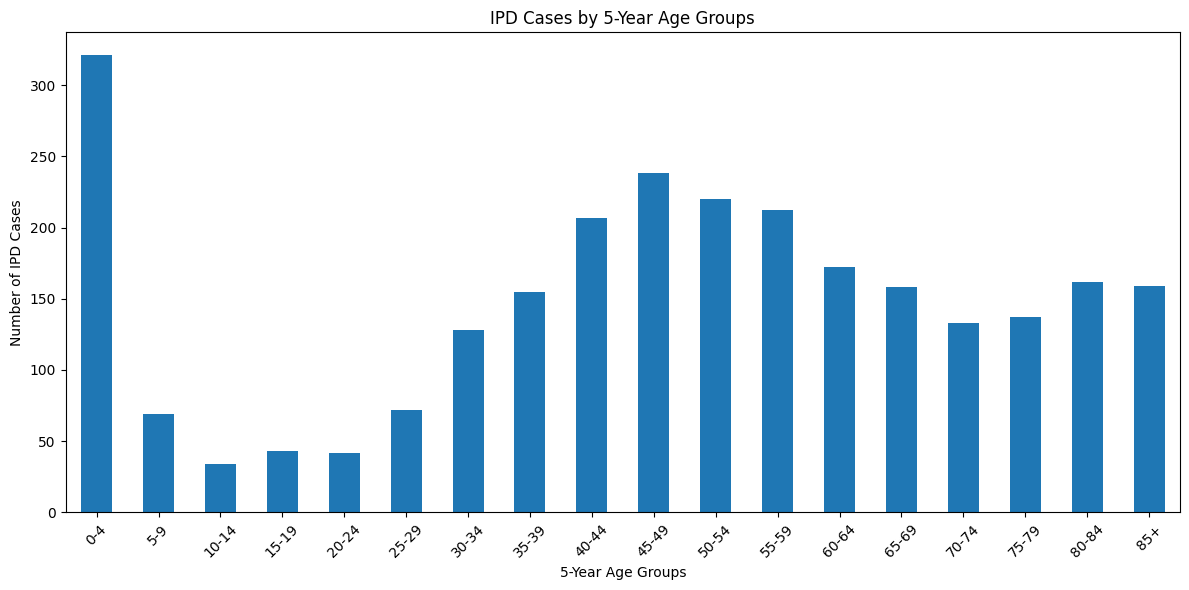

Index(['ID', 'Episode Date', 'Year', 'Age', 'Gender', 'HSDA', 'HA',
       'Offset PC', 'Age Group'],
      dtype='object')

In [11]:
# Define 5-year age groups
bins = [0, 4, 9, 14, 19, 24, 29, 34, 39, 44, 49, 54, 59, 64, 69, 74, 79, 84, float('inf')]
labels = ['0-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39',
          '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74',
          '75-79', '80-84', '85+']

# Create age group column
df_cleaned['Age Group'] = pd.cut(df_cleaned['Age'], bins=bins, labels=labels, right=True)

# Count cases by Age Group
age_group_counts = df_cleaned['Age Group'].value_counts().sort_index()

# Plot the number of IPD cases by Age Group
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
age_group_counts.plot(kind='bar')
plt.xlabel('5-Year Age Groups')
plt.ylabel('Number of IPD Cases')
plt.title('IPD Cases by 5-Year Age Groups')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

df_cleaned.columns

In [12]:
# Identify the 5-year age group with the fewest and most cases
fewest_cases_group = age_group_counts.idxmin()
most_cases_group = age_group_counts.idxmax()

print(f"Age Group with Fewest Cases: {fewest_cases_group} ({age_group_counts.min()} cases)")
print(f"Age Group with Most Cases: {most_cases_group} ({age_group_counts.max()} cases)")


Age Group with Fewest Cases: 10-14 (34 cases)
Age Group with Most Cases: 0-4 (321 cases)


##by place

In [13]:
# Group by Health Authority (HA) and Health Service Delivery Area (HSDA)
ha_hsda_counts = df_cleaned.groupby(['HA', 'HSDA']).size().reset_index(name='IPD Cases')

# Display the counts
print(ha_hsda_counts)


                   HA                       HSDA  IPD Cases
0              Fraser                Fraser East        184
1              Fraser               Fraser North        347
2              Fraser               Fraser South        343
3            Interior              East Kootenay         23
4            Interior          Kootenay Boundary         52
5            Interior                   Okanagan        238
6            Interior   Thompson Cariboo Shuswap        158
7            Northern                  Northeast         12
8            Northern          Northern Interior        123
9            Northern                  Northwest         25
10        Out of Prov                Out of Prov          2
11  Vancouver Coastal  North Shore/Coast Garibal        118
12  Vancouver Coastal                   Richmond         84
13  Vancouver Coastal                  Vancouver        608
14   Vancouver Island   Central Vancouver Island        130
15   Vancouver Island     North Vancouve

In [14]:
# Identify the HA with the most and fewest total IPD cases
ha_totals = ha_hsda_counts.groupby('HA')['IPD Cases'].sum().reset_index()

most_cases_ha = ha_totals.loc[ha_totals['IPD Cases'].idxmax()]
fewest_cases_ha = ha_totals.loc[ha_totals['IPD Cases'].idxmin()]

# Identify HSDA with the most and fewest IPD cases
most_cases_hsda = ha_hsda_counts.loc[ha_hsda_counts['IPD Cases'].idxmax()]
fewest_cases_hsda = ha_hsda_counts.loc[ha_hsda_counts['IPD Cases'].idxmin()]

# Display results
print(f"HA with the Most IPD Cases: {most_cases_ha['HA']} ({most_cases_ha['IPD Cases']} cases)")
print(f"HA with the Fewest IPD Cases: {fewest_cases_ha['HA']} ({fewest_cases_ha['IPD Cases']} cases)")

print(f"HSDA with the Most IPD Cases: {most_cases_hsda['HA']} - {most_cases_hsda['HSDA']} ({most_cases_hsda['IPD Cases']} cases)")
print(f"HSDA with the Fewest IPD Cases: {fewest_cases_hsda['HA']} - {fewest_cases_hsda['HSDA']} ({fewest_cases_hsda['IPD Cases']} cases)")


HA with the Most IPD Cases: Fraser (874 cases)
HA with the Fewest IPD Cases: Out of Prov (2 cases)
HSDA with the Most IPD Cases: Vancouver Coastal - Vancouver (608 cases)
HSDA with the Fewest IPD Cases: Out of Prov - Out of Prov (2 cases)


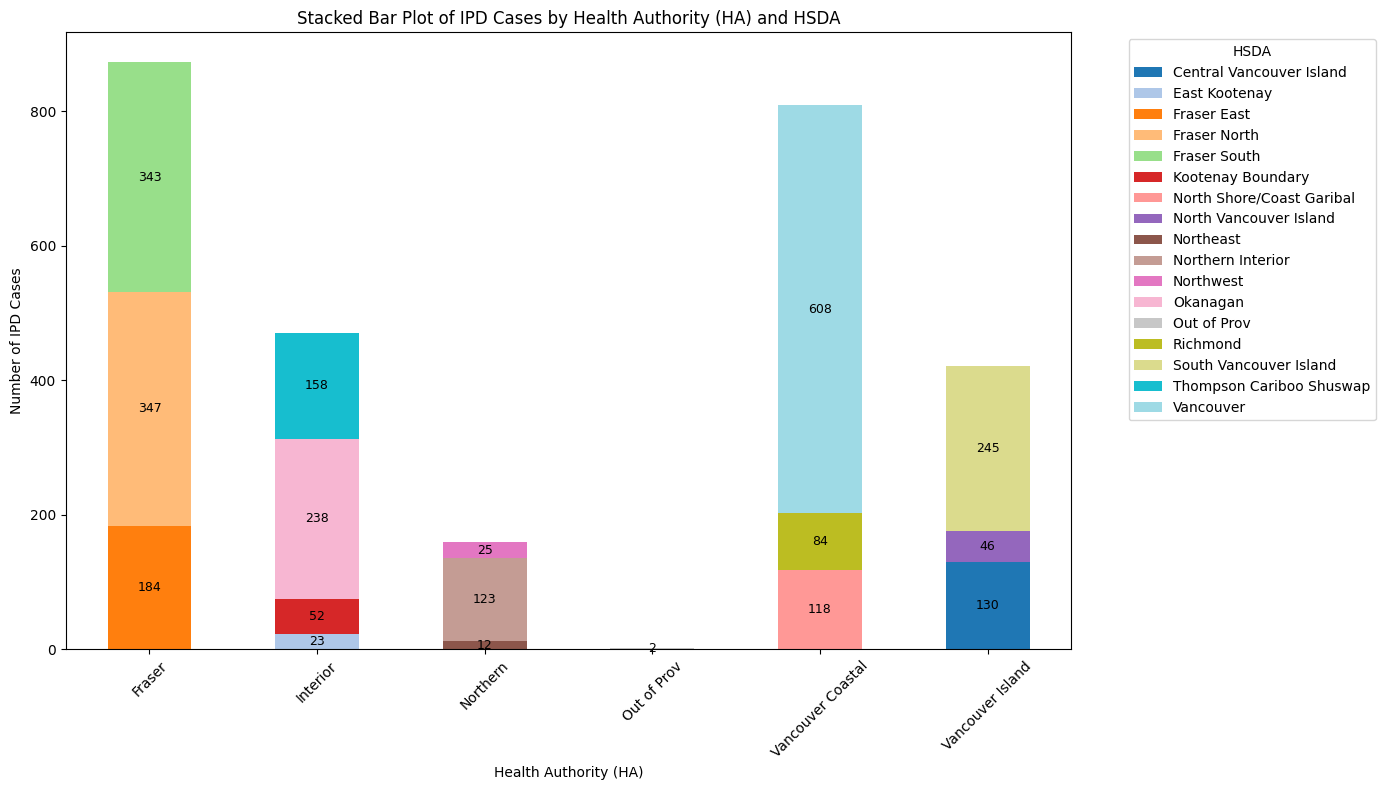

In [15]:
ha_hsda_counts = df_cleaned

# Grouping by Health Authority (HA) and HSDA to count the number of IPD cases
ha_hsda_counts_grouped = ha_hsda_counts.groupby(['HA', 'HSDA']).size().reset_index(name='IPD Cases')

# Pivoting the data for stacked bar plot
ha_hsda_pivot = ha_hsda_counts_grouped.pivot(index='HA', columns='HSDA', values='IPD Cases').fillna(0)

# Plotting the stacked bar plot with counts
ax = ha_hsda_pivot.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='tab20')

# Adding case counts to each bar segment
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,   # Center the text horizontally
                bar.get_y() + height / 2,            # Center the text vertically within the bar segment
                f'{int(height)}',                    # Convert height to an integer for display
                ha='center', va='center', fontsize=9, color='black'  # Formatting the text
            )

# Customizing the plot
plt.xlabel('Health Authority (HA)')
plt.ylabel('Number of IPD Cases')
plt.title('Stacked Bar Plot of IPD Cases by Health Authority (HA) and HSDA')
plt.xticks(rotation=45)
plt.legend(title='HSDA', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()


## by time

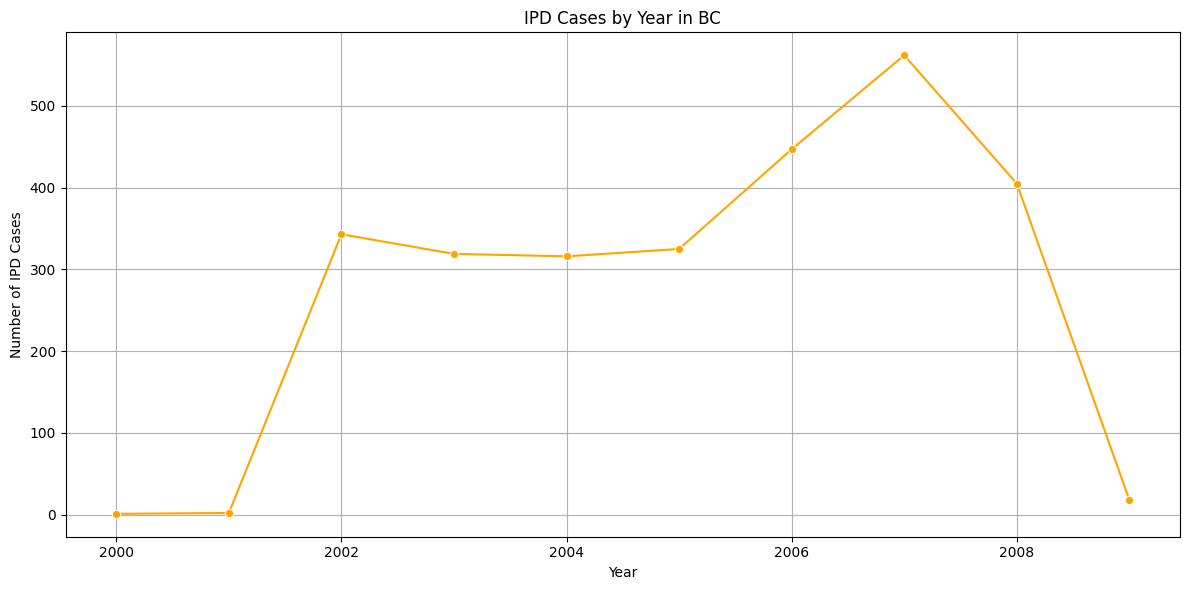

In [16]:
# Group by Year to count IPD cases
yearly_cases = df_cleaned.groupby('Year').size().reset_index(name='IPD Cases')

# Plotting the number of IPD cases by Year
plt.figure(figsize=(12, 6))
sns.lineplot(data=yearly_cases, x='Year', y='IPD Cases', marker='o', color='orange')

# Customize the plot
plt.xlabel('Year')
plt.ylabel('Number of IPD Cases')
plt.title('IPD Cases by Year in BC')
plt.grid(True)  # Add gridlines for better readability

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

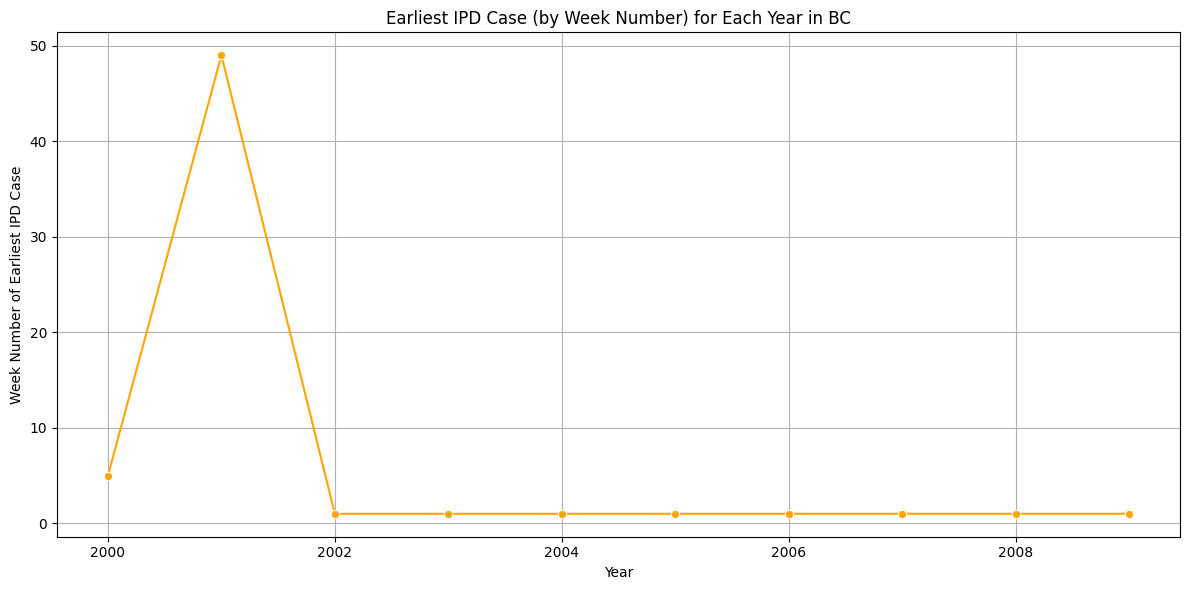

In [17]:

# Ensure 'Episode Date' is in datetime format
df_cleaned['Episode Date'] = pd.to_datetime(df_cleaned['Episode Date'], errors='coerce')

# Extract the week number and year from the 'Episode Date'
df_cleaned['Week Number'] = df_cleaned['Episode Date'].dt.isocalendar().week
df_cleaned['Year'] = df_cleaned['Episode Date'].dt.year

# Identify the earliest case of IPD for each year
earliest_case_per_year = df_cleaned.groupby('Year')['Week Number'].min().reset_index()

# Plotting the earliest week number by year
plt.figure(figsize=(12, 6))
sns.lineplot(data=earliest_case_per_year, x='Year', y='Week Number', marker='o', color='orange')

# Customize the plot
plt.xlabel('Year')
plt.ylabel('Week Number of Earliest IPD Case')
plt.title('Earliest IPD Case (by Week Number) for Each Year in BC')
plt.grid(True)

plt.tight_layout()
plt.show()


## by person and time

In [18]:
#import population size data by HSDA
filepath = '/content/drive/MyDrive/Population sizes by HSDA.csv'
population_data = pd.read_csv(filepath)


In [19]:
# Merge the cleaned IPD dataset with the population dataset
merged_data = pd.merge(
    df_cleaned,
    population_data,
    how='left',
    left_on=['HA', 'HSDA', 'Year'],
    right_on=['HA', 'HSDA', 'Year']
)

# Display the first few rows of the merged dataset
print(merged_data.head())


   ID Episode Date    Year  Age Gender          HSDA      HA Offset PC  \
0   1   2006-08-08  2006.0   11      F  Fraser South  Fraser    V3W3C7   
1   1   2006-08-08  2006.0   11      F  Fraser South  Fraser    V3W3C7   
2   1   2006-08-08  2006.0   11      F  Fraser South  Fraser    V3W3C7   
3   1   2006-08-08  2006.0   11      F  Fraser South  Fraser    V3W3C7   
4   1   2006-08-08  2006.0   11      F  Fraser South  Fraser    V3W3C7   

  Age Group  Week Number AgeGroup     Sex  Population  
0     10-14           32   a00_04    Male     19864.0  
1     10-14           32   a05_16    Male     54431.0  
2     10-14           32   a17_64    Male    215747.0  
3     10-14           32     a65+    Male     35213.0  
4     10-14           32   a00_04  Female     18176.0  


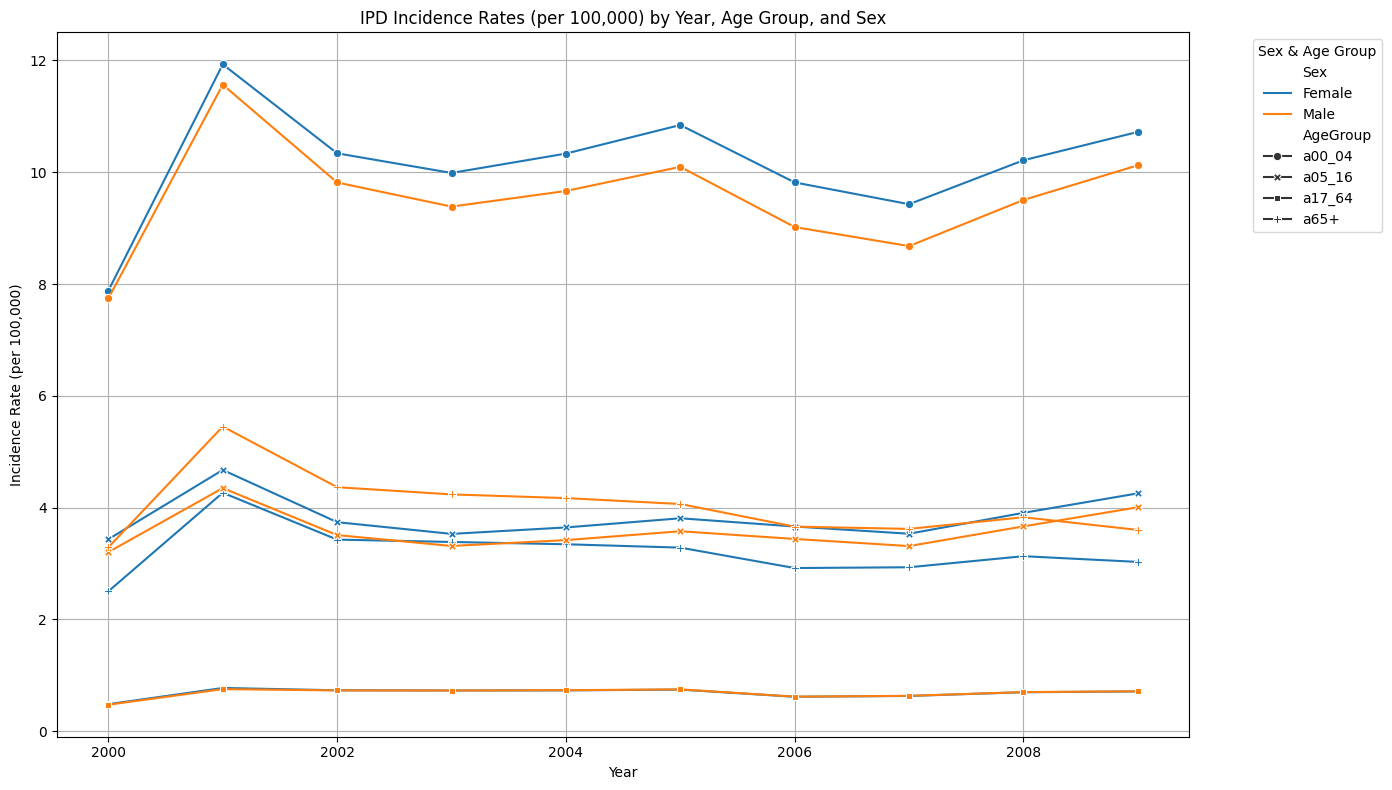

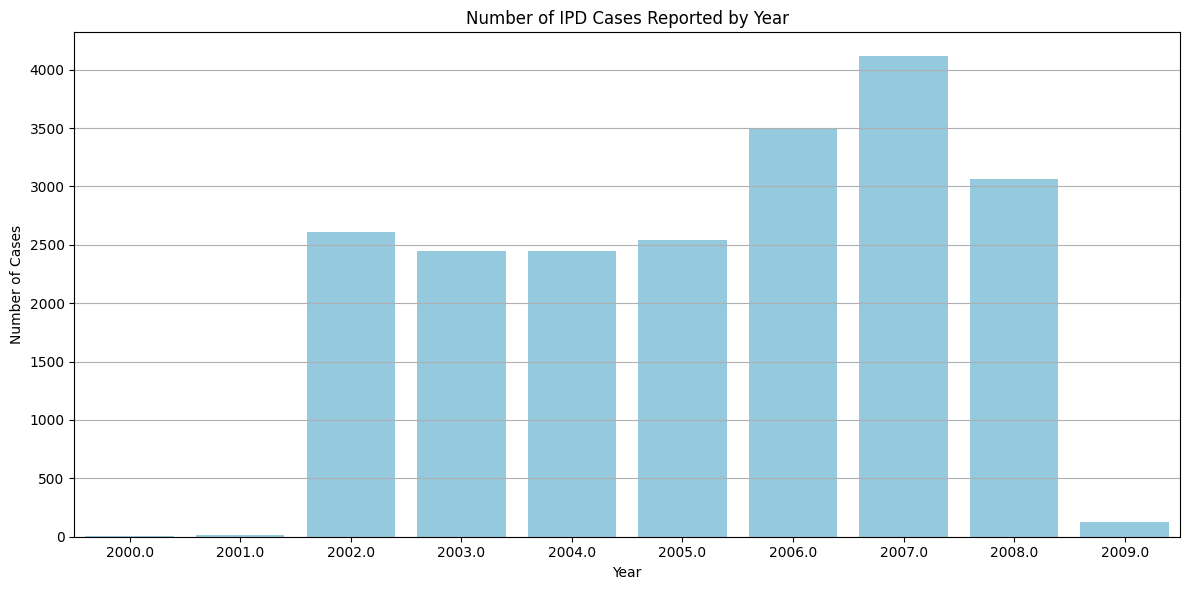

In [20]:
# Step 1: Calculate IPD incidence rates per 100,000 population
# Grouping the data by Year, AgeGroup, and Sex
incidence_data = merged_data.groupby(['Year', 'AgeGroup', 'Sex']).agg(
    Cases=('ID', 'count'),
    Population=('Population', 'sum')
).reset_index()

# Calculate incidence rate per 100,000
incidence_data['Incidence Rate (per 100,000)'] = (incidence_data['Cases'] / incidence_data['Population']) * 100000

# Step 2: Plotting

import matplotlib.pyplot as plt
import seaborn as sns

# Plot 1: IPD Incidence Rates by Year, Age Group, and Sex
plt.figure(figsize=(14, 8))
sns.lineplot(data=incidence_data, x='Year', y='Incidence Rate (per 100,000)', hue='Sex', style='AgeGroup', markers=True, dashes=False)

plt.title('IPD Incidence Rates (per 100,000) by Year, Age Group, and Sex')
plt.xlabel('Year')
plt.ylabel('Incidence Rate (per 100,000)')
plt.legend(title='Sex & Age Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Number of IPD Cases by Year
cases_per_year = merged_data.groupby('Year')['ID'].count().reset_index(name='Number of Cases')

plt.figure(figsize=(12, 6))
sns.barplot(data=cases_per_year, x='Year', y='Number of Cases', color='skyblue')

plt.title('Number of IPD Cases Reported by Year')
plt.xlabel('Year')
plt.ylabel('Number of Cases')
plt.grid(axis='y')

plt.tight_layout()
plt.show()


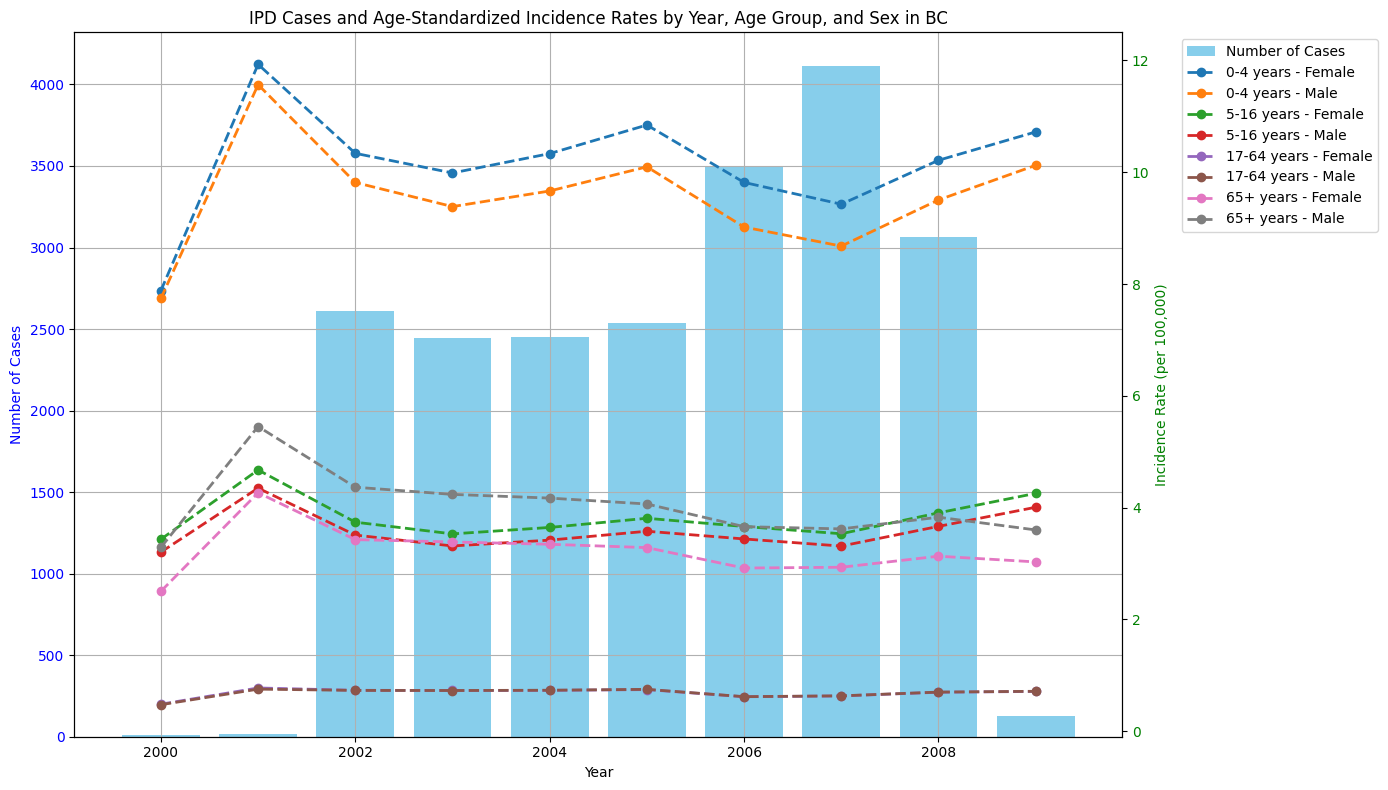

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# Step 1: Prepare Data
# Count of cases per year
cases_per_year = merged_data.groupby('Year')['ID'].count().reset_index(name='Number of Cases')

# Mapping age group codes to descriptive labels
age_group_labels = {
    'a00_04': '0-4 years',
    'a05_16': '5-16 years',
    'a17_64': '17-64 years',
    'a65+': '65+ years'
}

# Average incidence rate per year, age group, and sex
age_sex_rates = incidence_data.groupby(['Year', 'AgeGroup', 'Sex'])['Incidence Rate (per 100,000)'].mean().reset_index()

# Step 2: Plotting with Dual Axes
fig, ax1 = plt.subplots(figsize=(14, 8))

# Bar Plot: Number of IPD Cases (Primary Y-axis)
ax1.bar(cases_per_year['Year'], cases_per_year['Number of Cases'], color='skyblue', label='Number of Cases')
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Cases', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))  # Ensure integer x-axis

# Line Plot: Age-Standardized Incidence Rates (Secondary Y-axis)
ax2 = ax1.twinx()

# Plot age-standardized rates for each age group and sex
for (age_group, sex), group_data in age_sex_rates.groupby(['AgeGroup', 'Sex']):
    label = f'{age_group_labels.get(age_group, age_group)} - {sex}'
    ax2.plot(
        group_data['Year'],
        group_data['Incidence Rate (per 100,000)'],
        marker='o',               # Add markers for clarity
        linestyle='--',           # Dashed lines for distinction
        linewidth=2,              # Thicker lines for visibility
        label=label  # Legend label
    )

# Axis Labels for Secondary Y-axis
ax2.set_ylabel('Incidence Rate (per 100,000)', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Step 3: Final Customizations
plt.title('IPD Cases and Age-Standardized Incidence Rates by Year, Age Group, and Sex in BC')
ax1.grid(True)  # Add gridlines for readability

# Legends for Both Axes
lines_labels = [ax.get_legend_handles_labels() for ax in [ax1, ax2]]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
ax1.legend(lines, labels, bbox_to_anchor=(1.05, 1), loc='upper left')  # Position legend outside plot

# Adjust Layout
plt.tight_layout()
plt.show()


##By place and time


In [22]:
ipd_cases = pd.read_csv('/content/drive/MyDrive/df_cleaned (1).csv')
population_hsda = pd.read_csv('/content/drive/MyDrive/Population sizes by HSDA.csv')

# Standardize HSDA names to ensure consistency
ipd_cases['HSDA'] = ipd_cases['HSDA'].str.strip().str.replace('/', '-', regex=False)
population_hsda['HSDA'] = population_hsda['HSDA'].str.strip().str.replace('/', '-', regex=False)

# Correct known discrepancies in HSDA naming
ipd_cases['HSDA'] = ipd_cases['HSDA'].replace({'North Shore-Coast Garibal': 'North Shore-Coast Garibaldi'})

# Aggregate population data by HSDA and Year to get total population sizes
population_aggregated = population_hsda.groupby(['HSDA', 'Year'])['Population'].sum().reset_index()

# Merge the IPD case dataset with the aggregated population data
merged_data = pd.merge(ipd_cases, population_aggregated, how='left', on=['HSDA', 'Year'])

# Exclude 'Out of Prov' from the analysis
merged_data = merged_data[merged_data['HSDA'] != 'Out of Prov']

# 1) Count the number of cases per HSDA
case_counts = merged_data.groupby('HSDA').size().reset_index(name='Case_Count')

# 2) Calculate the crude rate per 100,000 population
# First, get the total population per HSDA
population_per_hsda = merged_data.groupby('HSDA')['Population'].sum().reset_index()

# Merge case counts with population data
crude_rate_data = pd.merge(case_counts, population_per_hsda, on='HSDA')

# Calculate the crude rate per 100,000 population
crude_rate_data['Crude_Rate_per_100k'] = (crude_rate_data['Case_Count'] / crude_rate_data['Population']) * 100000

crude_rate_data


,HSDA,Case_Count,Population,Crude_Rate_per_100k
0,Central Vancouver Island,130,32004146.0,0.406197
1,East Kootenay,23,1743301.0,1.319336
2,Fraser East,184,48312052.0,0.380857
3,Fraser North,346,195201682.0,0.177253
4,Fraser South,343,222959479.0,0.153840
5,Kootenay Boundary,52,4000186.0,1.299940
6,North Shore-Coast Garibaldi,118,31740346.0,0.371767
7,North Vancouver Island,46,5340872.0,0.861283
8,Northeast,12,774787.0,1.548813
9,Northern Interior,123,17566950.0,0.700178


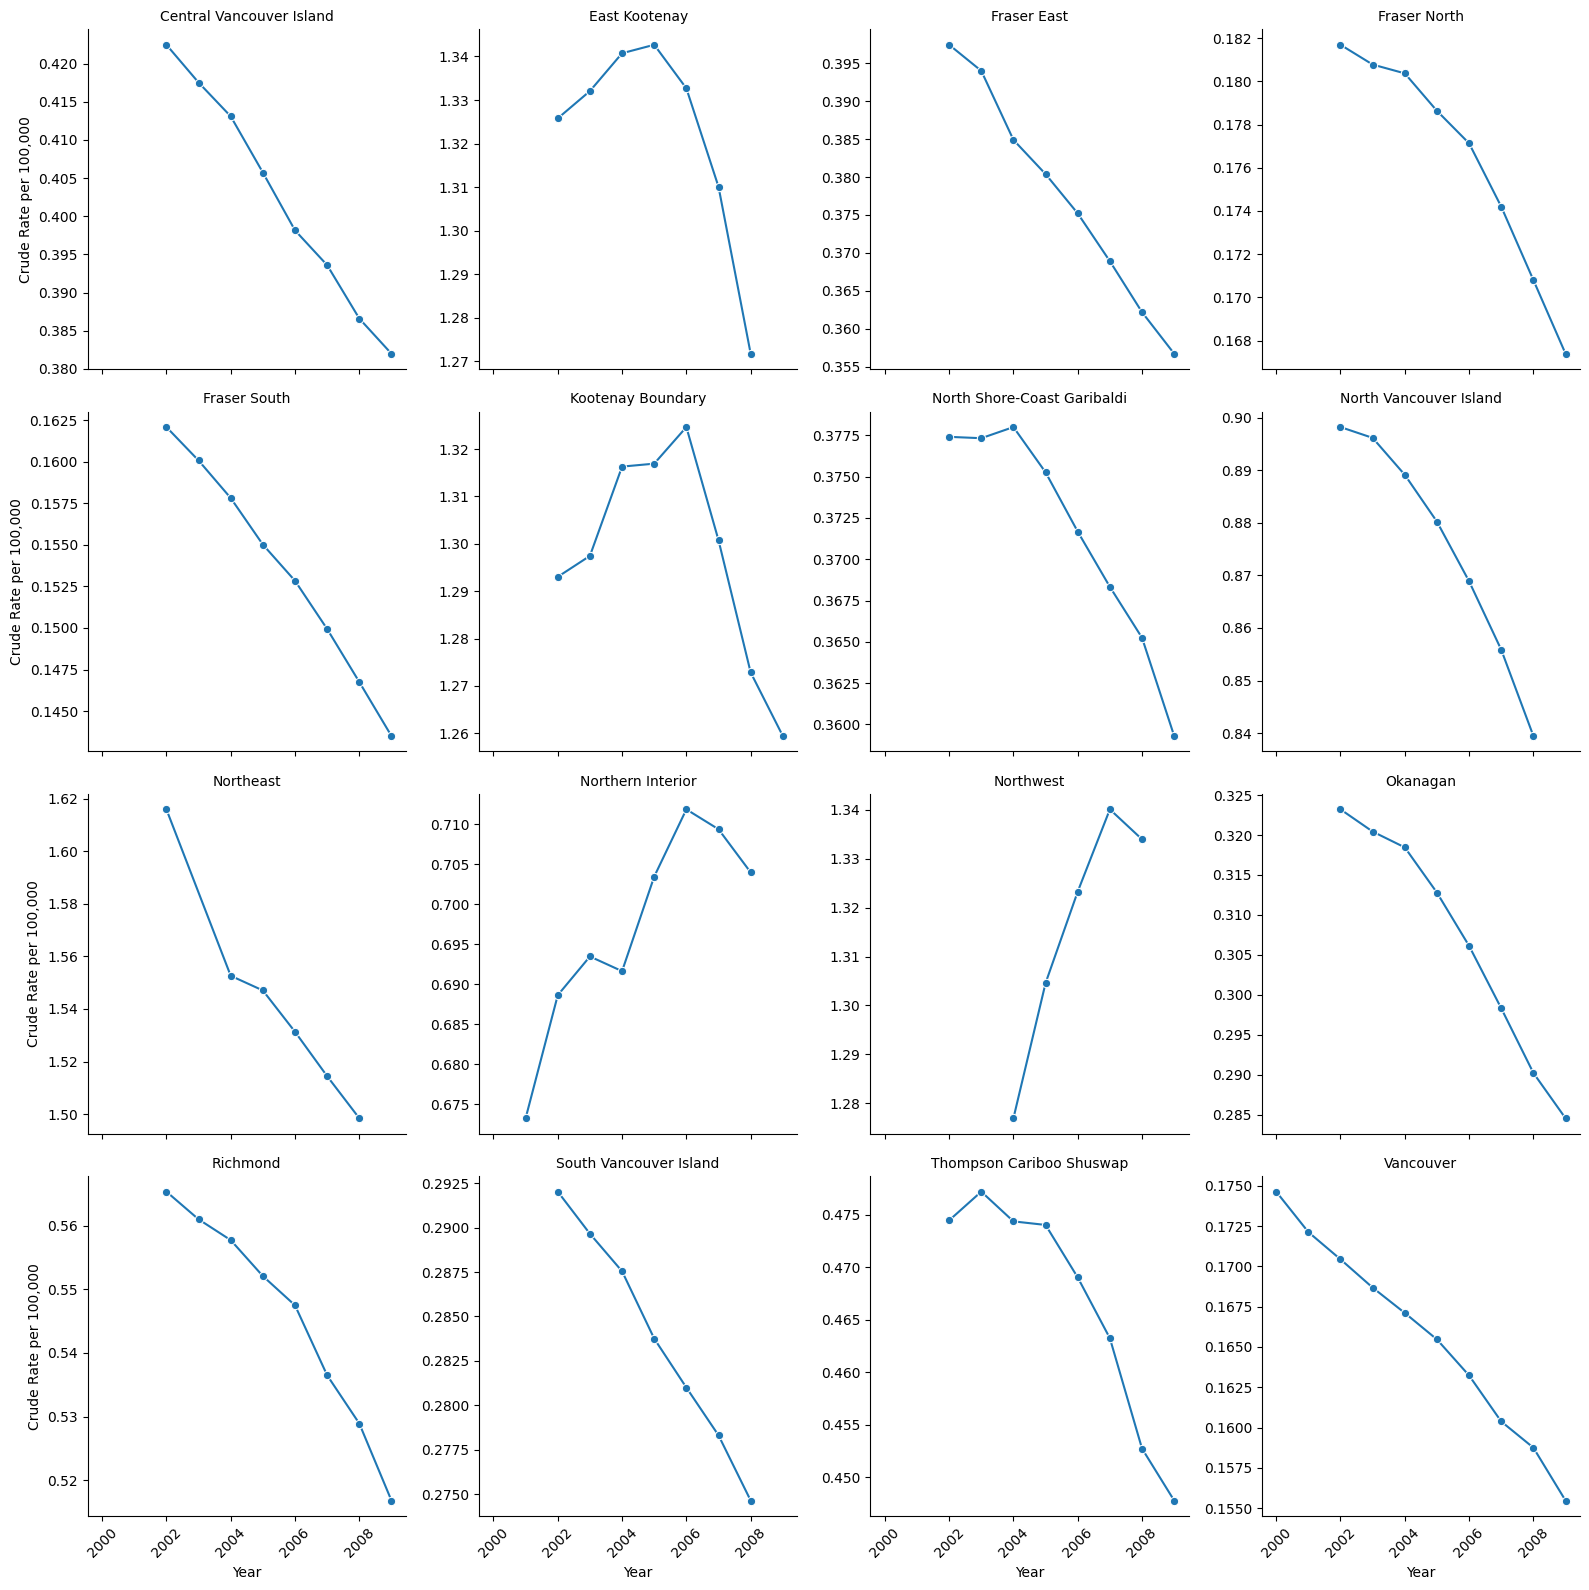

In [23]:
# Prepare the data: Calculate crude rates by HSDA and Year
crude_rate_by_year = merged_data.groupby(['HSDA', 'Year']).agg(
    Case_Count=('ID', 'size'),
    Population=('Population', 'sum')
).reset_index()

# Calculate the crude rate per 100,000 population
crude_rate_by_year['Crude_Rate_per_100k'] = (crude_rate_by_year['Case_Count'] / crude_rate_by_year['Population']) * 100000

# Exclude 'Out of Prov' again for plotting
crude_rate_by_year = crude_rate_by_year[crude_rate_by_year['HSDA'] != 'Out of Prov']

# Create facet plots for crude IPD case rates by HSDA, by year with labels every two years
g = sns.FacetGrid(crude_rate_by_year, col="HSDA", col_wrap=4, height=4, sharey=False)
g.map_dataframe(sns.lineplot, x="Year", y="Crude_Rate_per_100k", marker="o")

# Adjust plot labels and titles
g.set_titles("{col_name}")
g.set_axis_labels("Year", "Crude Rate per 100,000")

# Label every two years
years = sorted(crude_rate_by_year['Year'].unique())
every_two_years = [year for i, year in enumerate(years) if i % 2 == 0]

for ax in g.axes.flatten():
    ax.set_xticks(every_two_years)
    ax.set_xticklabels(every_two_years, rotation=45)

plt.tight_layout()
plt.show()